In [1]:
import os, random
import torch
import time
import numpy as np
import pandas as pd
import math
from rpy2 import robjects as ro
from rpy2.robjects import numpy2ri
import torch.optim as optim
import torch.nn as nn
from torch.distributions import Dirichlet, Multinomial
from scipy.io import loadmat
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt


base_dir = os.getcwd()

seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

population = "neonate" # neonate OR child
algorithm = "eava"   # eava OR insilicova OR interva

comsa_path = os.path.join(base_dir, "comsa_data", f"{population}.csv")
numpy2ri.activate()
mmat_path = os.path.join(base_dir, "comsa_data", f"Mmat_wo_{population}_{algorithm}")

# ─────────────────────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────────────────────
comsa_df = pd.read_csv(comsa_path,sep=r"\s+",engine="python",quotechar='"',header=0, index_col=0)
comsa_df.columns = comsa_df.columns.str.strip('"')
comsa_df.index   = comsa_df.index.str.strip('"')
comsa_df = comsa_df.apply(pd.to_numeric)
comsa_counts = comsa_df.loc[algorithm].to_numpy().astype(int).flatten()
K = len(comsa_counts) 
comsa_tensor = torch.tensor(comsa_counts, dtype=torch.float32)
n_total = int(comsa_tensor.sum().item())

n_samples = 1000
mmat_data = ro.r['readRDS'](mmat_path)
M = torch.tensor(mmat_data[:n_samples], dtype=torch.float32) 
N = M.shape[0]
print(f"[check] M shape: {tuple(M.shape)}  (expect [N={N}, K={K}, K={K}])")
M_context = M[:, :, :-1].reshape(N, -1)
print(f"[check] M_context shape: {tuple(M_context.shape)}  (expect [N={N}, K*(K-1)={K*(K-1)}])")

# ─────────────────────────────────────────────────────────────
# Prior
# ─────────────────────────────────────────────────────────────
eta = 4.0
phat = comsa_counts / n_total
gamma_prior = 1 + K * eta * torch.tensor(phat, dtype=torch.float32)
print("prior is ", gamma_prior)

# ─────────────────────────────────────────────────────────────
# Parameters
# ─────────────────────────────────────────────────────────────
log_beta = nn.Parameter(torch.zeros(K, dtype=torch.float32))
print(f"[check] log_beta shape: {tuple(log_beta.shape)}  (expect [K={K}])")

learning_rate = 5e-3
eps = 1e-10
max_steps = 10000

patience = 500      
min_delta = 1e-8    
clip_grad_norm = 5.0 

optimizer = optim.Adam([log_beta], lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.5, patience=patience,
    min_lr=1e-6
)

loss_values = []
start_time = time.time()

best_loss = float('inf')
best_state = None
no_improve = 0
printed_shapes_once = False

for step in range(max_steps):
    optimizer.zero_grad()

    alpha = torch.matmul(M.transpose(1, 2), torch.exp(log_beta)) 
    alpha = alpha.clamp_min(eps)  

    q = Dirichlet(alpha)
    p_samples = q.rsample()  

    # Term1: E_q[log q(p)]
    term1 = q.log_prob(p_samples)

    # Term2: E_q[log p(v | M, p)]
    probs = torch.matmul(M.transpose(1, 2), p_samples.unsqueeze(-1)).squeeze(-1) 
    probs = probs.clamp_min(eps) 
    probs = probs / probs.sum(dim=1, keepdim=True)  

    counts_batch = comsa_tensor.unsqueeze(0).expand(N, -1) 
    like = Multinomial(total_count=n_total, probs=probs)
    term2 = like.log_prob(counts_batch)

    # Term3: E_q[log p(p)] with prior Dirichlet(gamma_prior)
    prior = Dirichlet(gamma_prior)
    term3 = prior.log_prob(p_samples)

    # Loss = E_q[log q] - E_q[log p(v|M,p)] - E_q[log p(p)]
    loss_vec = term1 - term2 - term3
    loss = loss_vec.mean() 
    loss.backward()

    if clip_grad_norm is not None:
        torch.nn.utils.clip_grad_norm_([log_beta], clip_grad_norm)

    optimizer.step()
    scheduler.step(loss)

    loss_values.append(loss.item())

    if step % 200 == 0:
        with torch.no_grad():
            print(f"Step {step:4d} | Loss {loss.item():.6f} | ")

    current = loss.item()
    if best_loss - current > min_delta:
        best_loss = current
        best_state = log_beta.detach().clone()
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"[early-stop] No improvement > {min_delta} for {patience} steps. Stopping at step {step}.")
        break

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed: {elapsed_time:.2f}s")


[check] M shape: (1000, 5, 5)  (expect [N=1000, K=5, K=5])
[check] M_context shape: (1000, 20)  (expect [N=1000, K*(K-1)=20])
prior is  tensor([1.9660, 4.6883, 6.8617, 6.8836, 4.6004])
[check] log_beta shape: (5,)  (expect [K=5])
Step    0 | Loss 186.690857 | 
Step  200 | Loss 144.166107 | 
Step  400 | Loss 127.881233 | 
Step  600 | Loss 120.810844 | 
Step  800 | Loss 119.254860 | 
Step 1000 | Loss 119.599739 | 
Step 1200 | Loss 119.279160 | 
Step 1400 | Loss 119.471352 | 
Step 1600 | Loss 118.723465 | 
Step 1800 | Loss 119.022331 | 
Step 2000 | Loss 119.090813 | 
[early-stop] No improvement > 1e-08 for 500 steps. Stopping at step 2001.
Elapsed: 4.12s


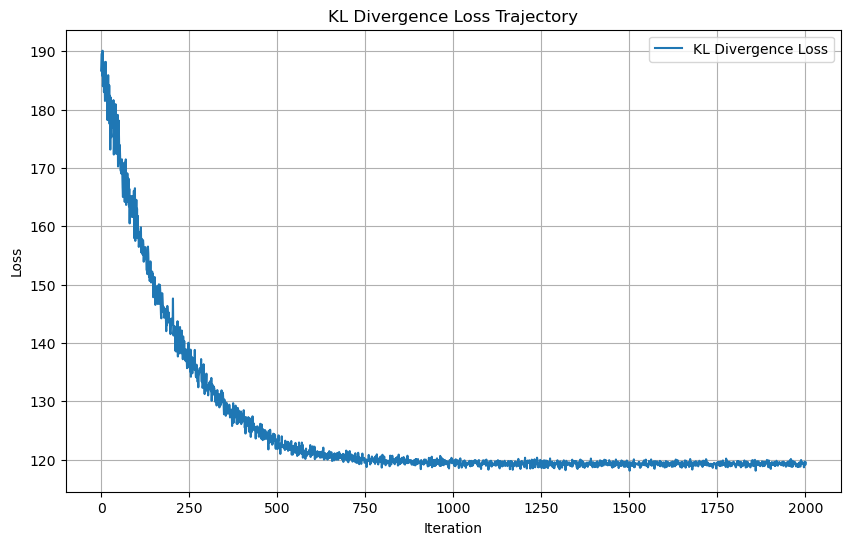

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='KL Divergence Loss')
plt.title('KL Divergence Loss Trajectory')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

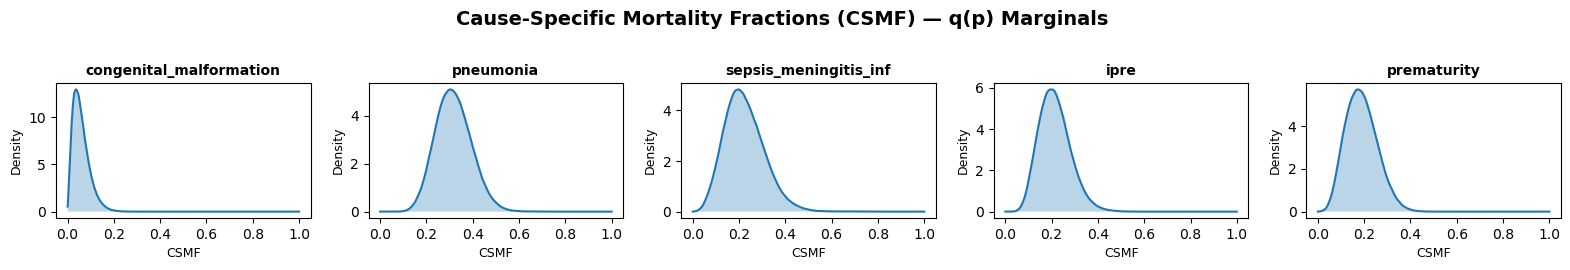

In [3]:
# ─────────────────────────────────────────────────────────────
# Marginal samples 
# ─────────────────────────────────────────────────────────────
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with torch.no_grad():
    alpha = torch.matmul(M.transpose(1, 2), torch.exp(log_beta)).clamp_min(1e-10)  

n_iterations = 1000
p_samples = torch.distributions.Dirichlet(alpha).sample((n_iterations,))
p_samples_flat = p_samples.reshape(-1, K).cpu().numpy()

if population == "neonate":
    dimension_names = ["congenital_malformation", "pneumonia", "sepsis_meningitis_inf", "ipre", "prematurity"]
else:
    dimension_names = ["malaria", "pneumonia", "diarrhea", "severe_malnutrition",
                       "hiv", "injury", "other_infections", "nn_causes"]

if len(dimension_names) != K:
    dimension_names = [f"cause_{i+1}" for i in range(K)]


df_samples = pd.DataFrame(p_samples_flat, columns=dimension_names)

n_cols = 5
n_rows = math.ceil(K / n_cols)

plt.figure(figsize=(3.2 * n_cols, 2.6 * n_rows))
for j, col in enumerate(df_samples.columns, start=1):
    ax = plt.subplot(n_rows, n_cols, j)
    vals = df_samples[col].to_numpy()

    xs = np.linspace(0.0, 1.0, 400)
    try:
        kde = gaussian_kde(vals)
        ys = kde(xs)
        ax.plot(xs, ys)
        ax.fill_between(xs, ys, alpha=0.3)
    except Exception:
        ax.hist(vals, bins=40, density=True)

    ax.set_title(col, fontsize=10, fontweight="bold")
    ax.set_xlabel("CSMF", fontsize=9)
    ax.set_ylabel("Density", fontsize=9)

plt.suptitle("Cause-Specific Mortality Fractions (CSMF) — q(p) Marginals", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()
